Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### We will import the data from google drive and unzip files to test and train folders to read the data

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

In [3]:
#umcomment this code if running on google colab and reading data from google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#google drive is mounted and the zip file is prsent at the root level. 
#we need to unzip the file provided by upgrad into seperate test and train folders
#Since the data provided is already seperated in train and test we can just unzip the file to root

#umcomment this code if running on google colab and reading data from google drive

#import os
#os.chdir('gdrive/My Drive')  #change dir

#!unzip -q CNN_assignment -d /




In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size= (img_height , img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size= (img_height, img_width),
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Let's visualize one instance of all the nine classes present in the dataset

In [10]:
import matplotlib.pyplot as plt

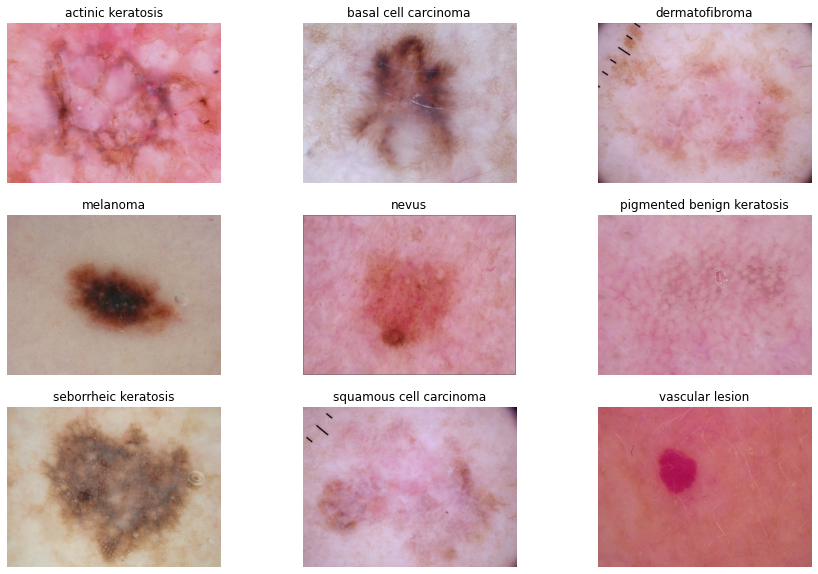

In [11]:
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [12]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(ex)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:

num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model =  tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [16]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 90, 90, 32)        0         
                                                        

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 242s 1s/step - loss: 2.0402 - accuracy: 0.2009 - val_loss: 2.0140 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 2.0045 - accuracy: 0.2483 - val_loss: 1.9830 - val_accuracy: 0.2416
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9747 - accuracy: 0.2567 - val_loss: 2.0308 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9420 - accuracy: 0.2891 - val_loss: 1.9831 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.9114 - accuracy: 0.2941 - val_loss: 1.8335 - val_accuracy: 0.3557
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8781 - accuracy: 0.3164 - val_loss: 1.9138 - val_accuracy: 0.3221
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.8474 - accuracy: 0.3320 - val_loss: 1.7244 - val_accuracy: 0.3982
Epoch 8/20
56

### It is evident that our model is not working as expected. This is a case of underfitting
The validation loss is not decreasing much and accuracy on traing and validation set is 45% and 46% respectively after 20 epochs. 
We need to revisit the loss function, optimizer, data pre processing (augmentation) etc.

## Create the model again

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training the model again (using different optimizer)

In [20]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6398 - accuracy: 0.4448 - val_loss: 1.4439 - val_accuracy: 0.5078
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4113 - accuracy: 0.5095 - val_loss: 1.4209 - val_accuracy: 0.5056
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3476 - accuracy: 0.5246 - val_loss: 1.3838 - val_accuracy: 0.5391
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2355 - accuracy: 0.5597 - val_loss: 1.3849 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1603 - accuracy: 0.5926 - val_loss: 1.3990 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0522 - accuracy: 0.6194 - val_loss: 1.4415 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 0.9948 - accuracy: 0.6440 - val_loss: 1.4788 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualizing the results

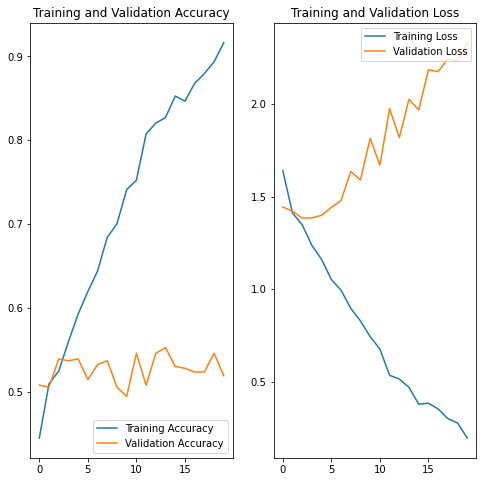

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Now we have encountered overfitting as training accuracy is as high as 91% but validation accuracy drops to 51%
###### Also we can see that after about 4 epochs the training accuracy keeps on increasing but validation accuracy around 51% to 54%

# We must solve the problem of overfitting

### Distribution of classes in the training dataset.
 Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

####  `seborrheic keratosis` class has the least number of samples
####  `melanoma`, `pigmented benign keratosis` and `basal cell carcinoma` classes dominate the data in terms proportionate number of samples

##  Rectify the class imbalance
Using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
path_to_training_dataset=r"/content/gdrive/My Drive/CNN_assignment/Train"
for i in class_names:
    print(path_to_training_dataset +'//'+ i)

/content/gdrive/My Drive/CNN_assignment/Train//actinic keratosis
/content/gdrive/My Drive/CNN_assignment/Train//basal cell carcinoma
/content/gdrive/My Drive/CNN_assignment/Train//dermatofibroma
/content/gdrive/My Drive/CNN_assignment/Train//melanoma
/content/gdrive/My Drive/CNN_assignment/Train//nevus
/content/gdrive/My Drive/CNN_assignment/Train//pigmented benign keratosis
/content/gdrive/My Drive/CNN_assignment/Train//seborrheic keratosis
/content/gdrive/My Drive/CNN_assignment/Train//squamous cell carcinoma
/content/gdrive/My Drive/CNN_assignment/Train//vascular lesion


In [28]:
path_to_training_dataset=r"/content/gdrive/My Drive/CNN_assignment/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +'//'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D2C060460>: 100%|██████████| 500/500 [00:17<00:00, 28.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2D14BAB460>: 100%|██████████| 500/500 [00:18<00:00, 27.17 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D800EE370>: 100%|██████████| 500/500 [00:18<00:00, 26.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F2D14BA2490>: 100%|██████████| 500/500 [01:36<00:00,  5.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F2D2C130250>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2D14B5E280>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F2D14BA2970>: 100%|██████████| 500/500 [00:42<00:00, 11.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D2C0964F0>: 100%|██████████| 500/500 [00:17<00:00, 27.80 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D2C0D4E80>: 100%|██████████| 500/500 [00:17<00:00, 27.95 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


## Train the model on the data created using Augmentor

In [30]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [31]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create your model (make sure to include normalization)

In [33]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model =  tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

In [34]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
epochs = 50

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 34s 59ms/step - loss: 1.9203 - accuracy: 0.2697 - val_loss: 1.5208 - val_accuracy: 0.4180
Epoch 2/50
169/169 [==============================] - 4s 24ms/step - loss: 1.4059 - accuracy: 0.4668 - val_loss: 1.2527 - val_accuracy: 0.5167
Epoch 3/50
169/169 [==============================] - 4s 24ms/step - loss: 1.1885 - accuracy: 0.5742 - val_loss: 1.1203 - val_accuracy: 0.5813
Epoch 4/50
169/169 [==============================] - 4s 24ms/step - loss: 1.0129 - accuracy: 0.6285 - val_loss: 1.0259 - val_accuracy: 0.6088
Epoch 5/50
169/169 [==============================] - 4s 24ms/step - loss: 0.9062 - accuracy: 0.6716 - val_loss: 0.8976 - val_accuracy: 0.6793
Epoch 6/50
169/169 [==============================] - 4s 24ms/step - loss: 0.7078 - accuracy: 0.7465 - val_loss: 0.8646 - val_accuracy: 0.6726
Epoch 7/50
169/169 [==============================] - 4s 23ms/step - loss: 0.5981 - accuracy: 0.7784 - val_loss: 0.7848 - val_accuracy: 0.7246
Epoch 8/5

## Visualize the model results

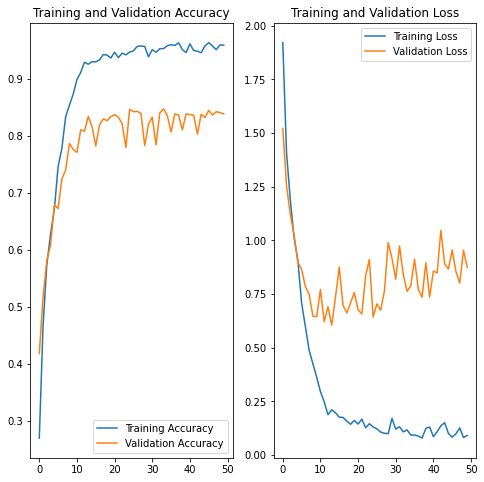

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Inference
We have solved the problem of overfitting and model is working good for validation set also.
We see oppurtunity to `early stop` during the training phase. However this model is good enough. We will run the model on test set in the end to see how it works

In [39]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [4 6 2 3 1 4 3 5 0 0 7 0 2 3 3 2 0 0 4 0 3 3 3 5 8 7 7 1 5 7 3 1]


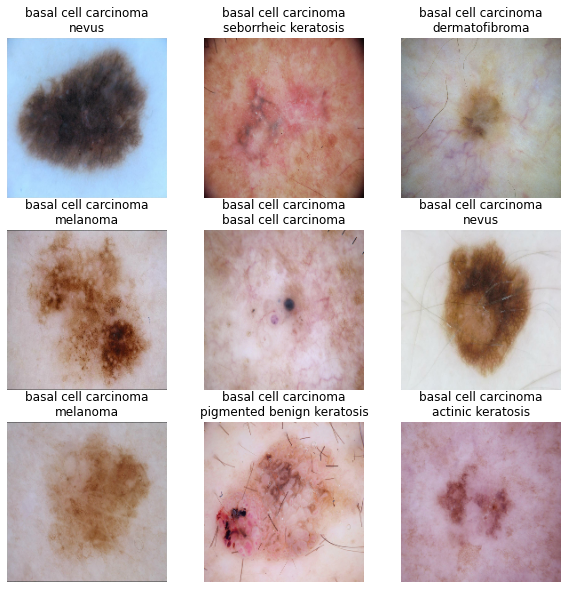

In [40]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")